In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
from scipy.interpolate import splprep, splev

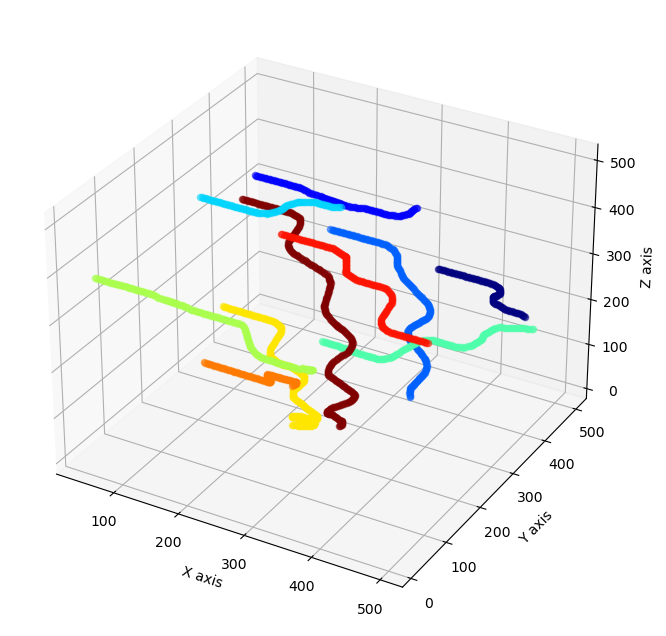

In [12]:
def is_within_bounds(point, volume, radius=1):
    x, y, z = point
    return radius <= x < volume.shape[0] - radius and radius <= y < volume.shape[1] - radius and radius <= z < volume.shape[2] - radius

def can_place_sphere(center, volume, radius=1, allow_fusion=False, fusion_chance=0):
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                if x**2 + y**2 + z**2 <= radius**2:
                    ix, iy, iz = center[0] + x, center[1] + y, center[2] + z
                    if not is_within_bounds((ix, iy, iz), volume, 0):
                        return False
                    if volume[ix, iy, iz] == 1:
                        if allow_fusion and random.random() < (fusion_chance / 100.0):
                            continue
                        return False
    return True


# def add_voxel_sphere_to_volume(volume, center, radius=1):
#     # Directly modify 'volume' without creating a copy.
#     for x in range(-radius, radius + 1):
#         for y in range(-radius, radius + 1):
#             for z in range(-radius, radius + 1):
#                 if x**2 + y**2 + z**2 <= radius**2 and is_within_bounds((center[0]+x, center[1]+y, center[2]+z), volume, 0):
#                     volume[center[0]+x, center[1]+y, center[2]+z] = 1

def add_sphere_with_optional_flattening(volume, center, radius=1, flat_side=None):
    cx, cy, cz = center
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                ix, iy, iz = cx + x, cy + y, cz + z

                dist_sq = x**2 + y**2 + z**2
                
                if flat_side:
                    if 'x' in flat_side and (radius - abs(x) < 5):
                        continue
                    if 'y' in flat_side and (radius - abs(y) < 5):
                        continue

                if dist_sq <= radius**2 and is_within_bounds((ix, iy, iz), volume, 0):
                    volume[ix, iy, iz] = 1



def update_volume_with_fiber(volume, fiber, radius=1, flat_side=None):
    for point in fiber:
        add_sphere_with_optional_flattening(volume, point, radius, flat_side)

def plot_fiber(ax, fiber, color='b'):
    for point in fiber:
        x, y, z = point
        ax.scatter(x, y, z, color=color, alpha=0.5)

def generate_and_count_fibers(volume, num_fibers, num_clusters, cluster_radius, min_length=50, max_length=100, radius=12, curve_amplitude=0.1, curve_frequency=0.1, preferred_direction=[1, 0, 0], bias=0.8, fusion_chance=0, flat_side=None, flat_side_percentage=0):
    successful_fibers = 0
    fibers = []
    total_attempts = 0
    max_total_attempts = 10000
    fibers_to_flatten = int(num_fibers * (flat_side_percentage / 100.0))
    flattened_fibers_indices = random.sample(range(num_fibers), fibers_to_flatten)
    
    colors = plt.cm.jet(np.linspace(0,1,num_fibers))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    while successful_fibers < num_fibers and total_attempts < max_total_attempts:

        current_flat_side = flat_side if successful_fibers in flattened_fibers_indices else None
        fiber = generate_3d_fiber_with_clustering(volume, num_clusters, cluster_radius, min_length, max_length, radius, curve_amplitude, curve_frequency, preferred_direction, bias, fusion_chance)
        if fiber is not None:
            update_volume_with_fiber(volume, fiber, radius, current_flat_side)
            plot_fiber(ax, fiber, color=colors[successful_fibers])
            ax.set_xlabel("X axis")
            ax.set_ylabel("Y axis")
            ax.set_zlabel("Z axis")
            fibers.append(fiber)
            successful_fibers += 1
        total_attempts += 1

    if successful_fibers < num_fibers:
        print(f"Warning: Only able to place {successful_fibers} fibers after {total_attempts} attempts.")

    plt.show()
    return successful_fibers, fibers

def generate_clusters(volume, num_clusters, cluster_radius):
    clusters = []
    attempts = 0
    max_attempts = num_clusters * 100
    while len(clusters) < num_clusters and attempts < max_attempts:
        potential_center = np.array([random.randint(cluster_radius, dim - cluster_radius - 1) for dim in volume.shape])
        if all(np.linalg.norm(potential_center - c) >= 2 * cluster_radius for c in clusters):
            clusters.append(potential_center)
        attempts += 1
    if len(clusters) != num_clusters:
        raise ValueError("Could not place all clusters within max attempts")
    return clusters

def generate_3d_fiber_with_clustering(volume, num_clusters, cluster_radius, min_length=50, max_length=100, radius=2, 
                                      curve_amplitude=0.1, curve_frequency=0.1, preferred_direction=[1, 0, 0], bias=0.8, fusion_chance=100):
    clusters = generate_clusters(volume, num_clusters, cluster_radius)
    
    # Choose a random cluster to start the fiber
    cluster_center = random.choice(clusters)
    center_point = cluster_center + np.random.uniform(-cluster_radius, cluster_radius, size=3)
    center_point = np.round(center_point).astype(int)  # Ensure the point is in the grid

    attempts = 0
    max_attempts = 1000
    while attempts < max_attempts:
        center_point = np.array([random.randint(radius, dim - radius - 1) for dim in volume.shape])
        if can_place_sphere(center_point, volume, radius, allow_fusion=True, fusion_chance=fusion_chance):
            break
        attempts += 1
    if attempts == max_attempts:
        return None

    fiber = [center_point]
    
    all_directions = [[1, 0, 0], [0, 1, 0], [0, 0, 1],
                      [-1, 0, 0], [0, -1, 0], [0, 0, -1],
                      [1, 1, 0], [1, 0, 1], [0, 1, 1],
                      [-1, -1, 0], [-1, 0, -1], [0, -1, -1],
                      [1, -1, 0], [1, 0, -1], [0, 1, -1],
                      [-1, 1, 0], [-1, 0, 1], [0, -1, 1]]
    all_directions = [np.array(d) for d in all_directions if d != preferred_direction]

    num_biased = int(bias * 100)
    num_other = 100 - num_biased
    num_other = min(num_other, len(all_directions)) 

    biased_direction_choices = [np.array(preferred_direction)] * num_biased
    
    biased_direction_choices.extend(random.sample(all_directions, k=num_other))

    direction = random.choice(biased_direction_choices).astype(float)

    # randomness, sinusoidal adjustment, predefined direction with bias

    step_size = radius / 6
    for step in range(max_length):
        curve = np.sin(step * curve_frequency) * curve_amplitude
        adjustment = np.array([curve if i == 0 else curve * random.uniform(-1, 1) for i in range(3)], dtype=float)
        direction += adjustment
        direction = direction / np.linalg.norm(direction)

        next_point = center_point + direction * step_size
        next_point_int = np.round(next_point).astype(int)

        if not is_within_bounds(next_point_int, volume, radius) or not can_place_sphere(next_point_int, volume, radius, allow_fusion=True, fusion_chance=fusion_chance):
            if len(fiber) >= min_length:
                break
            else:
                return None

        fiber.append(next_point_int)
        center_point = next_point_int

    return fiber


volume_dimensions = [512, 512, 512]
volume = np.zeros(volume_dimensions)
num_fibers = 10
num_clusters = 1
cluster_radius = 100
min_length = 100
max_length = 300
radius = 12
curve_amplitude = 0.1
curve_frequency = 0.1
preferred_direction = [1,0,0]
bias = 1
fusion_chance = 0
flat_side = 'y' # if preferred direction is x, flat_side should be either y or z
flat_side_percentage = 50

num_successful_fibers, fibers = generate_and_count_fibers(volume, num_fibers, num_clusters, cluster_radius, min_length, max_length, radius, curve_amplitude, curve_frequency, preferred_direction, bias, fusion_chance, flat_side, flat_side_percentage)


In [11]:
import nibabel as nib
import pydicom
import tifffile
from PIL import Image

def save_volume(volume, path, format):
    if format == '.npy':
        np.save(path, volume)
    elif format == '.nii': #for 3D slicer visualization
        nii_img = nib.Nifti1Image(volume.astype(np.int16), affine=np.eye(4))
        nib.save(nii_img, path)
    elif format == '.tiff':
        tifffile.imwrite(path, volume.astype(np.uint16))
    else:
        raise ValueError("Unsupported format")
   

save_volume(volume, 'volume_with_irregularities.nii', '.nii')

In [10]:
import imageio
import io 

volume = np.load('volume_with_irregularities.npy')
images = []
for z in range(volume.shape[2]):
    plt.figure(figsize=(6, 6))
    plt.imshow(volume[z, :, :], cmap='gray')
    plt.title(f'Slice at X = {z}')
    plt.ylabel('Y-axis')
    plt.axis('off') 

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = imageio.imread(buf)
    images.append(image)
    buf.close()
    
    plt.close()  

gif_path = 'volume_slices_master_fiber_X_irregular.gif'
imageio.mimsave(gif_path, images, duration=0.1)  

print(f"GIF saved at: {gif_path}")


/tmp/ipykernel_62833/3772444238.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(buf)


GIF saved at: volume_slices_master_fiber_X_irregular.gif


In [140]:
import numpy as np
import random



def add_sphere_with_optional_flattening(volume, center, radius=1, flat_side=None):
    cx, cy, cz = center
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                ix, iy, iz = cx + x, cy + y, cz + z

                dist_sq = x**2 + y**2 + z**2
        
                if flat_side:
                    if 'x' in flat_side and (radius - abs(x) < 4):
                        continue
                    if 'y' in flat_side and (radius - abs(y) < 4):
                        continue

                if dist_sq <= radius**2 and is_within_bounds((ix, iy, iz), volume, 0):
                    volume[ix, iy, iz] = 1





def is_within_bounds(point, volume, radius=1):
    x, y, z = point
    return radius <= x < volume.shape[0] - radius and radius <= y < volume.shape[1] - radius and radius <= z < volume.shape[2] - radius


volume_dimensions = [100, 100, 100]
volume = np.zeros(volume_dimensions, dtype=int)

center = (50, 50, 50)
radius = 12 


add_sphere_with_optional_flattening(volume, center=(50, 50, 50), radius=10, flat_side='y')




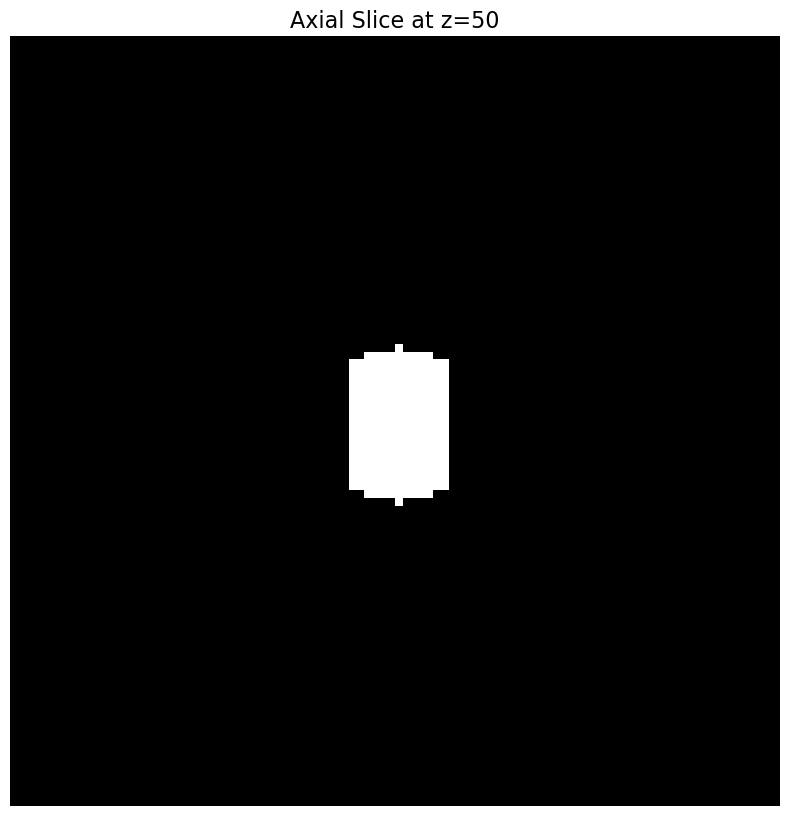

In [141]:
def show_axial_slice_enhanced(volume, z_coordinate):
    plt.figure(figsize=(10, 10))
    plt.imshow(volume[:, :, z_coordinate], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.title(f"Axial Slice at z={z_coordinate}", fontsize=16)
    plt.axis('off')  
    plt.show()

# Show an enhanced axial slice at z=50 for the previously modified volume
show_axial_slice_enhanced(volume, z_coordinate=50)
